In [ ]:
!pip install tensorflow==2.16.0rc0
!PYTHONHASHSEED=0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
import random as python_random
import os
import shutil
import glob

# Import TensorFlow/Keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Dropout, Activation, BatchNormalization, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Percorso del file ZIP su Google Drive
drive_zip_path = '/content/drive/MyDrive/DL_PROJECT/DATA/128.zip'
local_extract_path = '/content/Training_Data'
os.makedirs(local_extract_path, exist_ok=True
            )
# Decomprimere il file ZIP nella directory locale
with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

print("Decompressione completata.")

Decompressione completata.


### DATA GENERATOR

In [ ]:
import numpy as np  # Import the numpy library for array manipulation

# Function to load images from a given directory and list of image file names
def load_img(img_dir, img_list):
    images = []  # Initialize an empty list to store the images
    for image_name in img_list:  # Loop through each image name in the list
        if image_name.split('.')[-1] == 'npy':  # Check if the file is a .npy file
            volume = np.load(img_dir + image_name)  # Load the .npy file as a numpy array
            # Extract 128 images along the third axis (z-axis) from each volume
            for j in range(volume.shape[2]):
                images.append(volume[:, :, j, :])  # Append each slice to the images list
    images = np.array(images)  # Convert the list of images to a numpy array
    return images  # Return the numpy array of images

# Generator function to load and yield image and mask batches
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size=256):
    assert batch_size == 256, "Batch size must be 256 to match the number of slices per two volumes."  # Ensure batch size is 256

    L = len(img_list)  # Get the length of the image list

    while True:  # Infinite loop to keep yielding batches
        for i in range(0, L, 2):  # Iterate through the image list in steps of 2
            if i + 1 < L:  # Check if there are at least two more volumes to load
                img = load_img(img_dir, [img_list[i], img_list[i+1]])  # Load images from two volumes
                mask = load_img(mask_dir, [mask_list[i], mask_list[i+1]])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch
            else:
                # Handle the case where there is an odd number of volumes
                img = load_img(img_dir, [img_list[i]])  # Load images from the last volume
                mask = load_img(mask_dir, [mask_list[i]])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch

### ENVIROMMENT

In [ ]:
train_img_dir = '/content/Training_Data/X_train/'
train_mask_dir = '/content/Training_Data/Y_train/'

val_img_dir = '/content/Training_Data/X_val/'
val_mask_dir = '/content/Training_Data/Y_val/'

In [ ]:
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

### DEFINE PARAMETERS AND FUNCTIONS OF THE MODEL

In [ ]:
# Define the optimizer
# batch_size =  256
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list)//2),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
#Compute weight of classes

columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/Training_Data/Y_train/*.npy'))
for img in range(len(train_mask_list)):

  temp_image=np.load(train_mask_list[img])
  temp_image = np.argmax(temp_image, axis=3)
  val, counts = np.unique(temp_image, return_counts=True)

  conts_dict = {str(i): 0 for i in range(4)}
  for v, c in zip(val, counts):
    conts_dict[str(v)] = c

  row_df = pd.DataFrame([conts_dict])

  # Uso di pd.concat per aggiungere la nuova riga
  df = pd.concat([df, row_df], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(wt0, wt1, wt2, wt3)

0.26 8.56 29.69 27.28


In [ ]:
import tensorflow.keras.backend as K

def DiceCoefficient(y_true, y_pred, smooth = 1e-6):

    y_pred = tf.keras.activations.softmax(y_pred, axis = -1)

    # Cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # Flatten label and prediction tensors
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    intersection = K.sum(inputs * targets)
    dice = (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return dice


In [ ]:
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

In [ ]:
IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy", DiceCoefficient, Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]


### MODEL ARCHITECTURE

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Activation, concatenate, SpatialDropout2D
from tensorflow.keras.models import Model

l2 = tf.keras.regularizers.L2(l2 = 1e-4)

def conv_block_2d(input, n_filters):
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout2D( 0.2, data_format = "channels_last")(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters):
    x = conv_block_2d(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_regularizer = l2)(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters)
    return x


In [ ]:
def build_unet_2d(input_shape, n_classes, num_filters):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, num_filters)
    s2, p2 = encoder_block_2d(p1, 2*num_filters)
    s3, p3 = encoder_block_2d(p2, 4*num_filters)
    #s4, p4 = encoder_block_2d(p3, 8*num_filters)

    b1 = conv_block_2d(p3, 8*num_filters)

    #d1 = decoder_block_2d(b1, s4, 8*num_filters)
    d2 = decoder_block_2d(b1, s3, 4*num_filters)
    d3 = decoder_block_2d(d2, s2, 2*num_filters)
    d4 = decoder_block_2d(d3, s1, num_filters)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)  # esempio di input_shape 2D
n_classes = 4

model = build_unet_2d(input_shape, n_classes, 32)
model.compile(optimizer = optim, loss = CFC_loss , metrics = metrics)
model.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │          1,184 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 128, 128, 32)   │              0 │ activation[0][0]       │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 64, 64, 64)     │              0 │ activation_2[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ spatial_dropout2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 1,931,620 (7.37 MB)

 Trainable params: 1,928,804 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
train_img_dir = '/content/Training_Data/X_train/'
train_mask_dir = '/content/Training_Data/Y_train/'

val_img_dir = '/content/Training_Data/X_val/'
val_mask_dir = '/content/Training_Data/Y_val/'

In [ ]:
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [ ]:
batch_size = 256

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list)//2
val_steps_per_epoch = len(val_img_list)//2

print(steps_per_epoch, val_steps_per_epoch)

169 36


In [ ]:
# Callback per salvare il miglior modello basato sulla loss di validazione
checkpoint_path = "/content/drive/MyDrive/DL_PROJECT/2D_Unet_final.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only=True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Monitorare la loss di validazione
    patience = 10,           # Numero di epoche con nessun miglioramento dopo le quali l'addestramento verrà fermato
    restore_best_weights = True, # Ripristina i pesi del miglior modello visto durante l'addestramento
    verbose = 1
  )

csv = keras.callbacks.CSVLogger("/content/drive/MyDrive/DL_PROJECT/hist_2D_final.csv", separator=",", append=False)

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 20,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [early_stopping_callback, csv]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.4993 - dice_coefficient: 0.2775 - loss: 0.7885 - one_hot_io_u: 0.2519 - one_hot_io_u_1: 0.2054 - one_hot_io_u_2: 0.0573 - one_hot_io_u_3: 0.0754 - one_hot_mean_io_u: 0.1475 - val_accuracy: 0.9500 - val_dice_coefficient: 0.3313 - val_loss: 1.2520 - val_one_hot_io_u: 0.6922 - val_one_hot_io_u_1: 0.0243 - val_one_hot_io_u_2: 0.0000e+00 - val_one_hot_io_u_3: 0.0012 - val_one_hot_mean_io_u: 0.1794
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8178 - dice_coefficient: 0.3387 - loss: 0.4567 - one_hot_io_u: 0.3512 - one_hot_io_u_1: 0.2371 - one_hot_io_u_2: 0.0934 - one_hot_io_u_3: 0.1647 - one_hot_mean_io_u: 0.2116 - val_accuracy: 0.9609 - val_dice_coefficient: 0.3793 - val_loss: 0.9044 - val_one_hot_io_u: 0.7854 - val_one_hot_io_u_1: 0.2593 - val_one_hot_io_u_2: 0.0695 - val_one_hot_io_u_3: 0.2680 - val_one_hot_mean_io_u: 0.3456
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8419 - dice

In [ ]:
model.save('/content/drive/MyDrive/DL_PROJECT/2D_Unet_final_1.keras', overwrite=True)

In [ ]:
model.save_weights('/content/drive/MyDrive/DL_PROJECT/2D_Unet_final_1.weights.h5', overwrite=True)

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'dice_coefficient', 'loss', 'one_hot_io_u', 'one_hot_io_u_1', 'one_hot_io_u_2', 'one_hot_io_u_3', 'one_hot_mean_io_u', 'val_accuracy', 'val_dice_coefficient', 'val_loss', 'val_one_hot_io_u', 'val_one_hot_io_u_1', 'val_one_hot_io_u_2', 'val_one_hot_io_u_3', 'val_one_hot_mean_io_u'])

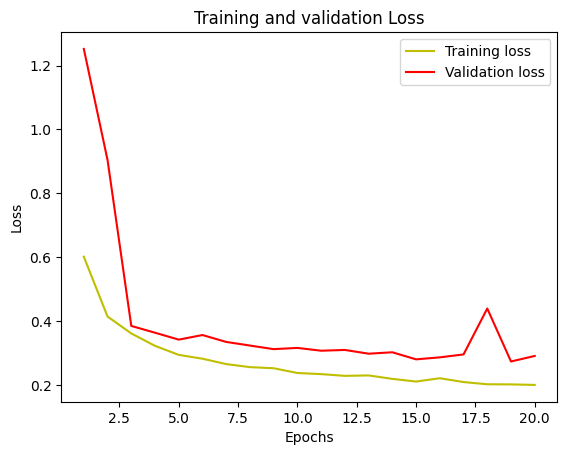

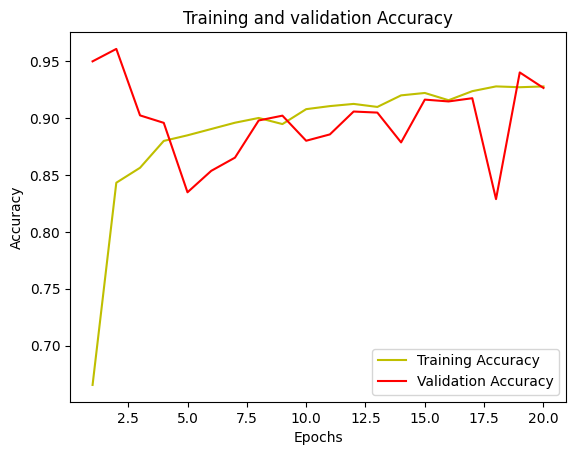

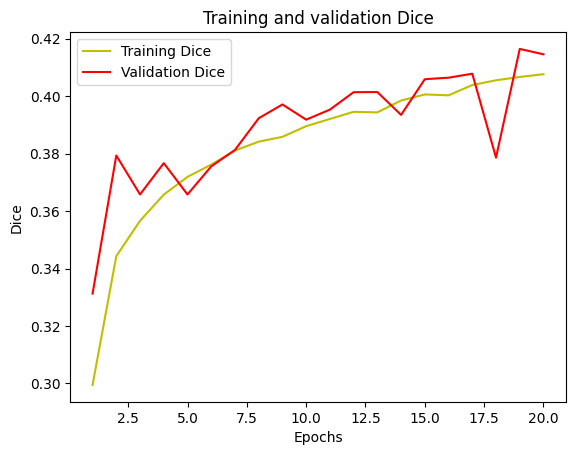

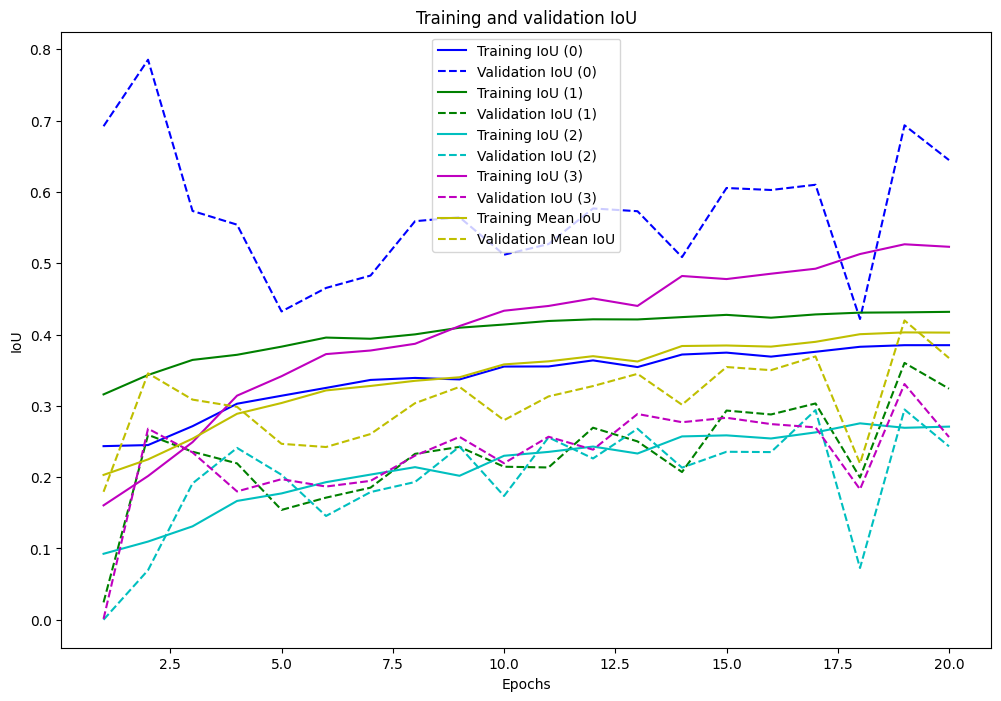

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
model_2 = keras.saving.load_model("/content/drive/MyDrive/DL_PROJECT/2D_Unet_final_1.keras", custom_objects= {'DiceCoefficient': DiceCoefficient})